In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device))

from google.colab import drive
drive.mount('/content/drive')


%cd /content/drive/My Drive/Colab Notebooks

Found GPU at: /device:GPU:0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [0]:
# Importing Libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import argparse, copy

from model import *
from utils import *
from measures import *

In [3]:
avg_train_losses, avg_test_losses, avg_difference_test_train, avg_var_grad = [], [], [], []

seeds = [12345, 1234, 123]
for seed in seeds:
    print ("seed:::", seed)
    torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model Hyperparamters
    batch_size = 64
    epochs = 14
    lr = 3e-6 # good one - lowest validation loss among others
    gamma = 0.7
    momentum = 0.9

    use_cuda = torch.cuda.is_available()
    train_loader, val_loader, test_loader, train_size, val_size = dataloaders(batch_size, use_cuda, seed)
    print (train_size, val_size, len(test_loader.dataset))

    model = Net().to(device)

    train_losses, test_losses = [], []
    var_grad_list = []

    optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

    for epoch in range(1, epochs + 1):
        train_loss, grad_norms, grad_avg = train_get_grad(model, device, train_loader, optimizer, epoch, batch_size)
        train_losses.append(train_loss)
        test_loss = test(model, device, test_loader, batch_size)
        test_losses.append(test_loss)
        scheduler.step()

        # computing var_score over one epoch
        variance_score = compute_grad_variance(grad_norms, grad_avg)
        var_grad_list.append(variance_score)
    
    avg_train_losses.append(train_losses) 
    avg_test_losses.append(test_losses)
    avg_var_grad.append(var_grad_list)

    # print train and test losses and their difference
    difference_test_train = np.array(test_losses)  - np.array(train_losses)
    # print ("diff_test_train::\n", difference_test_train)
    avg_difference_test_train.append(difference_test_train)


seed::: 12345
54000 6000 10000

Test set: Average loss: 0.6932, Accuracy: 7525/10000 (75%)


Test set: Average loss: 0.6466, Accuracy: 7638/10000 (76%)


Test set: Average loss: 0.6223, Accuracy: 7674/10000 (77%)


Test set: Average loss: 0.6134, Accuracy: 7706/10000 (77%)


Test set: Average loss: 0.6045, Accuracy: 7718/10000 (77%)


Test set: Average loss: 0.6021, Accuracy: 7724/10000 (77%)


Test set: Average loss: 0.5955, Accuracy: 7726/10000 (77%)


Test set: Average loss: 0.5953, Accuracy: 7732/10000 (77%)


Test set: Average loss: 0.5929, Accuracy: 7734/10000 (77%)


Test set: Average loss: 0.5930, Accuracy: 7734/10000 (77%)


Test set: Average loss: 0.5932, Accuracy: 7733/10000 (77%)


Test set: Average loss: 0.5899, Accuracy: 7735/10000 (77%)


Test set: Average loss: 0.5927, Accuracy: 7734/10000 (77%)


Test set: Average loss: 0.5917, Accuracy: 7735/10000 (77%)

seed::: 1234
54000 6000 10000

Test set: Average loss: 0.2457, Accuracy: 9298/10000 (93%)


Test set: Average loss:

In [4]:
print (avg_train_losses)
print (avg_test_losses)
print (avg_difference_test_train)
print (avg_var_grad)

[[0.8670552924134155, 0.6715083279033408, 0.6354980897599769, 0.6156465685198093, 0.6036139454392461, 0.5959335783081597, 0.5909935224324606, 0.5874978139537488, 0.5853419856508196, 0.583672471997721, 0.5826157523204365, 0.5818005933722049, 0.5813203692895259, 0.5810472483954159], [0.43300891581092965, 0.2268103755110107, 0.18766772654790306, 0.16589207090967073, 0.1527995727691464, 0.14463042052930566, 0.13919387332282926, 0.13567486400517384, 0.13314877496370206, 0.13139232167735768, 0.1302789017884723, 0.12944362622849043, 0.12886045177542202, 0.12847051994601413], [0.4295198499220666, 0.22947994822645074, 0.19054604110736134, 0.16885579194679362, 0.15617784373550478, 0.1476996052542357, 0.1422264360827151, 0.13852177418203432, 0.13595267044053683, 0.13426527145243652, 0.133017151638583, 0.13221764036617573, 0.1316241988850431, 0.13124029561259312]]
[[0.6931700736853728, 0.6466331979271712, 0.6223080076609447, 0.6133612314606928, 0.6044670920463124, 0.6020514659441201, 0.59551794494

In [5]:
# Average over 3 random seeds
avg_train_losses = np.mean(np.array(avg_train_losses), 0)
avg_test_losses = np.mean(np.array(avg_test_losses), 0)
avg_difference_test_train = np.mean(np.array(avg_difference_test_train), 0)
avg_var_grad = np.mean(np.array(avg_var_grad), 0)


# print ("avg_train_losses:::\n", avg_train_losses)
# print ("avg_test_losses:::\n", avg_test_losses)
print ("average difference list::\n", avg_difference_test_train)


average difference list::
 [-0.18264228 -0.0257153  -0.01336051 -0.0041935   0.00029459  0.00384732
  0.00471218  0.00630916  0.00703269  0.0082027   0.0083501   0.00800961
  0.00919984  0.00902916]


NameError: ignored

In [6]:
print ("avg_var_gard::\n", avg_var_grad)

avg_var_gard::
 [1.6731883 1.5930246 1.4957409 1.420867  1.3922323 1.3539358 1.3408984
 1.3290349 1.318215  1.3110362 1.3170658 1.3066876 1.3076572 1.3059348]


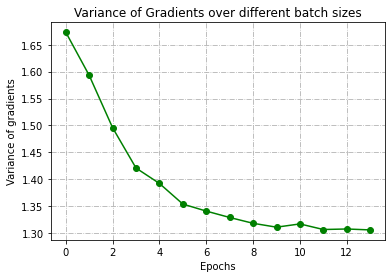

In [8]:
import numpy as np
plt.plot(np.arange(epochs), avg_var_grad, marker='o', color = "g")
plt.grid(True, linestyle='-.')
plt.title("Variance of Gradients over different batch sizes")
plt.ylabel("Variance of gradients")
plt.xlabel("Epochs")
plt.show()	  